### Imports

In [1]:
import gym
import gym.spaces
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from collections import deque, namedtuple
from tqdm import tqdm
import datetime
import random
import pickle
from pathlib import Path
import os
from natsort import natsorted

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def set_seed(seed, env):
    env.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

### Wrappers

In [4]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.noop_action = 0
        assert self.env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self):
        self.env.reset()
        noops = self.env.unwrapped.np_random.integers(1, self.noop_max+1)
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset()
        return obs

In [5]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        gym.Wrapper.__init__(self, env)
        self._skip = skip
        self._obs_buffer = np.zeros((2,) + self.env.observation_space.shape, dtype=np.uint8)

    def step(self, action):
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, _, info = self.env.step(action)
            if i == 0: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs            
            total_reward += reward
            if done:
                break
        max_frame = self._obs_buffer.max(axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        obs = self.env.reset()
        return obs

In [6]:
class TimeLimit(gym.Wrapper):
    def __init__(self, env, max_episode_steps=None):
        super(TimeLimit, self).__init__(env)
        self._max_episode_steps = max_episode_steps
        self._elapsed_steps = 0

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self._elapsed_steps += 1
        if self._elapsed_steps >= self._max_episode_steps:
            done = True
            info['TimeLimit.truncated'] = True
        return obs, reward, done, info

    def reset(self):
        self._elapsed_steps = 0
        obs = self.env.reset()
        return obs

In [7]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.lives = self.env.ale.lives()
        assert self.env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(self.env.unwrapped.get_action_meanings()) >= 3

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

    def step(self, action):
        if self.lives > self.env.ale.lives():
            self.lives = self.env.ale.lives()
            action = 1
        obs, reward, done, info = self.env.step(action)
        return obs, reward, done, info

In [8]:
class ClipReward(gym.RewardWrapper):
    def __init__(self, env, min_r=-1, max_r=1):
        super().__init__(env)
        self.min_r = min_r
        self.max_r = max_r

    def reward(self, reward):
        if reward < 0:
            return self.min_r
        elif reward > 0:
            return self.max_r
        else:
            return 0

    def step(self, action):
        obs, rew, done, info = self.env.step(action)
        return obs, self.reward(rew), done, info

In [9]:
class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84):
        super().__init__(env)
        self._width = width
        self._height = height
        num_channels = 3

        new_space = gym.spaces.Box(
            low = 0,
            high = 255,
            shape = (self._height, self._width, num_channels),
            dtype = np.uint8
        )
        original_space = self.observation_space
        self.observation_space = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
       return  cv.resize(
            obs, (self._width, self._height), interpolation=cv.INTER_AREA
        )

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return self.observation(obs), reward, done, info

    def reset(self):
        obs = self.env.reset()
        return self.observation(obs)

In [10]:
class FrameStack(gym.Wrapper):
    def __init__(self, env, k=2):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        self.observation_space = gym.spaces.Box(
            low = 0,
            high = 255,
            shape = (2,84,84,3),
            dtype = env.observation_space.dtype
        )
        
    def reset(self):
        obs = self.env.reset()
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_obs()

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_obs(), reward, done, info

    def _get_obs(self):
        assert len(self.frames) == self.k
        return self.frames

In [11]:
class OpticalFlowCV(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(
            low = 0,
            high = 255,
            shape = env.observation_space.shape,
            dtype = np.float32
        )

    def observation(self, obs):
        assert np.array(obs).shape == (2, 84, 84, 3)
        frames = obs

        first_frame = np.array(frames)[0].astype('uint8')
        prev_gray = cv.cvtColor(first_frame, cv.COLOR_RGB2GRAY)

        mask = np.zeros_like(first_frame)
        mask[..., 1] = 255

        frame = np.array(frames)[1].astype('uint8')
        gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)

        flow = cv.calcOpticalFlowFarneback(prev_gray, gray,
                                        None, 
                                        0.5, 5, 5, 5, 7, 1.5, 0)

        magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])

        mask[..., 0] = angle * 180 / np.pi / 2
        mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)

        flow = cv.cvtColor(mask, cv.COLOR_HSV2RGB)
        obs[0] = flow
        obs[1] = np.array(frames)[1]
        assert np.array(obs).shape == (2, 84, 84, 3)
        return obs

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return self.observation(obs), reward, done, info

    def reset(self):
        return self.env.reset()

In [12]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(
            low = 0,
            high = 255,
            shape = (6,84,84),
            dtype = np.float32
        )

    def observation(self, obs):
        assert np.array(obs).shape == (2, 84, 84, 3)
        obs = np.array(obs).astype(np.float32)
        obs[1] = obs[1] / 255.0
        obs = obs.reshape(6,84,84)
        return obs

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return self.observation(obs), reward, done, info

    def reset(self):
        obs = self.env.reset()
        return self.observation(obs)

In [13]:
class EpisodicLifeEnv(gym.Wrapper):
    """
    Termina el episodio cuando se pierde una vida, pero solo reinicia si
    se pierden todas.
    """
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.is_done = True
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.is_done = done
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            done = True
        self.lives = lives
        return obs, reward, done, info
    
    def reset(self):
        if self.is_done:
            obs = self.env.reset()
        else:
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

### Ambiente

In [14]:
def make_atari(env_id, max_episode_steps=1_000, noop_max=30, skip=4, sample=False):
    env = gym.make(env_id, render_mode=None)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max)
    env = MaxAndSkipEnv(env, skip)
    if max_episode_steps is not None:
        env = TimeLimit(env, max_episode_steps=max_episode_steps)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    if sample == False:
        env = ClipReward(env)
        env = EpisodicLifeEnv(env)
    env = WarpFrame(env)
    env = FrameStack(env)
    env = OpticalFlowCV(env)
    env = ScaledFloatFrame(env)
    return env

#### TEST

GAME = 'MsPacmanNoFrameskip-v4'

env = make_atari(GAME, sample=True)

start = env.reset()

start.shape

plt.imshow(start[0])
plt.show()

plt.imshow(start[1])
plt.show()

step, _, _, _ = env.step(2)

step = step.reshape(2,84,84,3)

plt.imshow(step[0])
plt.show()

plt.imshow(step[1])
plt.show()

### DQN

In [15]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

net = DQN(env.observation_space.shape, env.action_space.n).to(device)
net

### Experience Replay

In [16]:
Experience = namedtuple('Experience', field_names=['state','action','reward','done','next_state'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, *args):
        self.buffer.append(Experience(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

### Agent

In [17]:
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = self.env.reset()
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0, device='cuda'):
        done_reward = None

        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        
        self.exp_buffer.append(self.state, action, reward, done, new_state)
        self.state = new_state

        if done:
            done_reward = self.total_reward
            self._reset()

        return done_reward


### Función de entrenamiento

In [18]:
def training(env_name, replay_memory_size=50_000, max_frames=5_000_000, gamma=0.99, batch_size=32,  \
            learning_rate=0.00025, sync_target_frames=10_000, net_update=4, replay_start_size=50_000, \
            eps_start=1, eps_min=0.1, seed=2109, device='cuda', verbose=True):
    """
    Función de entrenamiento.
    """
    path = "dictsOpt/" + env_name + "_opt"
    Path(path).mkdir(parents=True, exist_ok=True)
    
    env = make_atari(env_name, max_episode_steps=1_000)
    buffer = ExperienceReplay(replay_memory_size)
    agent = Agent(env, buffer)
    set_seed(seed=seed, env=env)
    
    net        = DQN(env.observation_space.shape, env.action_space.n).to(device)
    target_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    
    epsilon = eps_start
    eps_decay = (eps_start - eps_min) / replay_memory_size
    
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    total_rewards = []

    best_mean_reward = None
    start_time = datetime.datetime.now()

    for frame in tqdm(range(1, max_frames+1), desc=env_name):        
        reward = agent.play_step(net, epsilon, device)

        if reward is not None:
            total_rewards.append(reward)
            mean_reward = np.mean(total_rewards[-100:])
            
            time_passed = datetime.datetime.now() - start_time

            if best_mean_reward is None or best_mean_reward < mean_reward:
                torch.save(net.state_dict(), path + "/" + env_name + "_opt_best.dat")
                best_mean_reward = mean_reward

        if len(buffer) < replay_start_size:
            continue

        epsilon = max(epsilon-eps_decay, eps_min)

        if frame % net_update == 0:
            sardn = buffer.sample(batch_size)
            batch = Experience(*zip(*sardn))
            
            states_v = torch.tensor(np.array(batch.state)).to(device)
            next_states_v = torch.tensor(np.array(batch.next_state)).to(device)
            actions_v = torch.tensor(batch.action).to(device)
            rewards_v = torch.tensor(batch.reward).to(device)
            done_mask = torch.BoolTensor(batch.done).to(device)

            state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
            next_state_values = target_net(next_states_v).max(1)[0]
            next_state_values[done_mask] = 0.0
            next_state_values = next_state_values.detach()
            expected_state_action_values = next_state_values*gamma + rewards_v
            
            loss_t = nn.HuberLoss()(state_action_values, expected_state_action_values) # MSELoss()(input,target)

            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()

        if frame % sync_target_frames == 0:
            target_net.load_state_dict(net.state_dict())

        if frame % (max_frames / 10) == 0:
            if verbose:
                print("{}:  {} games, best result {:.3f}, mean reward {:.3f}, eps {:.2f}, time {}".format(
                    frame, len(total_rewards), max(total_rewards), mean_reward, epsilon, time_passed))
            torch.save(net.state_dict(), path + "/" + env_name + "_opt_" + str(int((frame)/(max_frames/10))) + ".dat")

    print("Training finished")
    print("{}:  {} games, mean reward {:.3f}, eps {:.2f}, time {}".format(
            frame, len(total_rewards), mean_reward, epsilon, time_passed))
         
    pkl_file = "dictsOpt/" + env_name + "_opt/" + env_name + "_total_opt.pkl"
    with open(pkl_file, 'wb+') as f:
        pickle.dump(total_rewards, f)
    return total_rewards


### Training

In [19]:
#GAME_NAME = "MsPacmanNoFrameskip-v4"

In [20]:
#pacman = training(env_name=GAME_NAME, max_frames=10_000_000)

### Evaluación

In [19]:
def sample(game, model, model_name, n_samples=100, verbose=True):
    '''
    Obtiene 'n_samples' muestras de la red entrenada.
    '''
    game = game + 'NoFrameskip-v4'
    model = 'dicts/' + model + '/' + model_name
    env = make_atari(game, sample=True)
    net = DQN(env.observation_space.shape, env.action_space.n)
    net.load_state_dict(torch.load(model, map_location=lambda storage, loc: storage))
    
    rewards = np.zeros(n_samples)

    for i in range(n_samples):
    
        state = env.reset()
        total_reward = 0.0
        
        while True:
            
            state_v = torch.tensor(np.array([state], copy=False))
            q_vals = net(state_v).data.numpy()[0]
            action = np.argmax(q_vals)

            state, reward, done, _ = env.step(action)
            total_reward += reward

            if done:
                break
        
        if verbose:
            print('Model: {}, Game: {}, Reward: {}'.format(model, i+1,total_reward))

        rewards[i] = total_reward

    #print("Model: {}, Mean Reward: {}, Max Reward: {}, Min Reward: {}".format(model_name, np.mean(rewards), max(rewards), min(rewards)))
    return rewards

In [20]:
def get_dats_files(game_name):
    dats50 = [x for x in os.listdir('dicts/' + game_name + '_OldOpt_50k/') if 'dat' in x]
    dats75 = [x for x in os.listdir('dicts/' + game_name + '_OldOpt_75k/') if 'dat' in x]
    try:
        dats100 = [x for x in os.listdir('dicts/' + game_name + '_OldOpt_100k/') if 'dat' in x]
        dats150 = [x for x in os.listdir('dicts/' + game_name + '_OldOpt_150k/') if 'dat' in x]
        return natsorted(dats50), natsorted(dats75), natsorted(dats100), natsorted(dats150)
    except:
        pass
    return natsorted(dats50), natsorted(dats75)

In [21]:
def sample_model(env, samples=100):
    dats_array = get_dats_files(env)
    game_rewards = []
    for dats in dats_array:
        model_rewards = []
        mod = '_'.join(dats[0].split('_')[:-1])
        for model in tqdm(dats, desc=mod):
            rw = sample(env_name=env, model=mod, model_name=model, n_samples=samples, verbose=False)
            model_rewards.append(rw)
        game_rewards.append(model_rewards)
    pkl_file = "samples/" + env + "_sample_rewards.pkl"
    with open(pkl_file, 'wb+') as f:
        pickle.dump(game_rewards, f)
    return np.array(game_rewards, dtype=object)

In [22]:
import pickle

In [23]:
def open_pkl_file(file):
    Rewards = []
    with (open(file, "rb")) as openfile:
        while True:
            try:
                Rewards.append(pickle.load(openfile))
            except EOFError:
                break
    return np.array(Rewards, dtype=object)[0]

In [96]:
def find_stats(file=None, rws=None):
    if file:
        rewards = open_pkl_file(file).astype('float32')[0]
    else:
        rewards = rws.astype('float32')
    return rewards

In [51]:
def game_names(directory=None):
    files = os.listdir(directory)
    files = list(set([f.split('_')[0] for f in files if ".pkl" in f]))
    return natsorted(np.array(files))

In [66]:
randomSamples = open_pkl_file('samples/randomSamples.pkl')
randomSamples

array([['Adventure', 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ['AirRaid', 475.0, 375.0, ..., 525.0, 125.0, 100.0],
       ['Alien', 80.0, 120.0, ..., 70.0, 90.0, 110.0],
       ...,
       ['WizardOfWor', 600.0, 400.0, ..., 2600.0, 800.0, 400.0],
       ['YarsRevenge', 4485.0, 4554.0, ..., 4002.0, 2622.0, 3657.0],
       ['Zaxxon', 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [243]:
doneGames = set([f.split('_')[0] for f in os.listdir('samples') if "_sample_rewards_1M" in f])
doneDQN = set([f.split('_')[0] for f in os.listdir('samples') if "DQN" in f])

In [251]:
unsharedGames = doneGames-doneDQN
sharedGames = sorted(list(doneGames-unsharedGames))
sharedGames;
#FROSTBITE, KRULL, SEAQUEST, YARSREVENGE FALTAN EN DQN

In [70]:
for game in randomSamples:
    print('Game: {}, Mean: {}'.format(game[0], np.mean(game[1:])))

Game: Adventure, Mean: 0.0
Game: AirRaid, Mean: 461.6666666666667
Game: Alien, Mean: 94.33333333333333
Game: Amidar, Mean: 1.0
Game: Assault, Mean: 310.1
Game: Asterix, Mean: 263.3333333333333
Game: Asteroids, Mean: 1565.6666666666667
Game: Atlantis, Mean: 29773.333333333332
Game: BankHeist, Mean: 12.666666666666666
Game: BattleZone, Mean: 1933.3333333333333
Game: BeamRider, Mean: 297.8666666666667
Game: Berzerk, Mean: 208.33333333333334
Game: Bowling, Mean: 25.3
Game: Boxing, Mean: -0.3
Game: Breakout, Mean: 1.1
Game: Carnival, Mean: 926.6666666666666
Game: Centipede, Mean: 3067.133333333333
Game: ChopperCommand, Mean: 800.0
Game: CrazyClimber, Mean: 2353.3333333333335
Game: Defender, Mean: 3820.0
Game: DemonAttack, Mean: 251.66666666666666
Game: DoubleDunk, Mean: -15.933333333333334
Game: ElevatorAction, Mean: 6986.666666666667
Game: Enduro, Mean: 0.0
Game: FishingDerby, Mean: -92.93333333333334
Game: Freeway, Mean: 0.0
Game: Frostbite, Mean: 100.66666666666667
Game: Gopher, Mean: 34

In [ ]:
def getData(game):
    rewardsOPT = find_stats('samples/' + game + '_sample_rewards_1M.pkl')
    rewardsDQN = find_stats('samples/' + game + '_DQNSample_rewards_1M.pkl')

    
    return 

In [232]:
rewards = find_stats('samples/DoubleDunk_sample_rewards_1M.pkl')
rewardsDQN = find_stats('samples/DoubleDunk_DQNSample_rewards_1M.pkl')

arg = np.argmax(np.mean(rewards, axis=1))
arg2 = np.argmax(np.mean(rewardsDQN))

In [233]:
np.mean(rewards, axis=1), np.mean(rewardsDQN, axis=1)

(array([-20.133333, -22.2     , -19.666666, -19.      , -23.2     ,
        -21.933332, -20.733334, -20.266666, -23.8     , -19.933332,
        -22.666666, -19.466667, -16.933332, -19.733334, -21.933332,
        -21.066668, -22.666666, -21.133333, -19.2     , -20.8     ,
        -17.8     , -20.2     , -22.533333, -20.4     , -20.066668],
       dtype=float32),
 array([-23.533333, -23.8     , -23.733334, -24.      , -23.8     ,
        -24.      , -23.533333, -23.466667, -24.      , -23.533333,
        -23.8     , -24.      , -23.733334, -23.6     , -23.466667,
        -23.733334, -23.666666, -23.933332, -23.866667, -22.866667,
        -24.      , -23.4     , -23.666666, -23.933332, -22.933332],
       dtype=float32))

In [234]:
rewards[arg], np.mean(rewards[arg]), rewardsDQN[arg2], np.mean(rewardsDQN[arg2])

(array([-20.,  -8., -24., -22., -16., -20., -22., -16., -12., -18., -18.,
        -18., -20., -14.,  -6., -16., -20., -22., -20., -14., -16., -14.,
        -22., -12., -18., -10., -14., -14., -20., -22.], dtype=float32),
 -16.933332,
 array([-24., -24., -24., -24., -22., -24., -24., -24., -22., -22., -24.,
        -24., -24., -24., -24., -24., -24., -24., -24., -22., -24., -24.,
        -24., -24., -22., -22., -24., -22., -24., -24.], dtype=float32),
 -23.533333)

In [44]:
maxDifDunk, meanDifDunk, minDifDunk, argDifDunk = find_stats('samples/DoubleDunk_sample_rewards_10M.pkl')

In [46]:
meanDifDunk

array([-19.866667, -22.8     , -19.4     , -22.2     , -22.066668,
       -23.6     , -19.6     , -20.266666, -23.333334, -20.666666,
       -23.733334, -21.      , -21.2     , -23.266666, -22.466667,
       -23.333334, -22.933332, -23.733334, -23.533333, -22.666666,
       -21.933332, -22.8     , -23.333334, -23.733334, -22.733334,
       -20.733334], dtype=float32)

In [42]:
maxRaftDunk, meanRaftDunk, minRaftDunk, argRaftDunk = find_stats('samples/old/DoubleDunk_Sample_rewards_1M.pkl')

In [43]:
meanRaftDunk

array([-15.8     , -12.833333, -13.466666, -10.133333, -10.633333,
       -12.8     ,  -8.9     , -12.3     , -10.633333, -10.2     ,
        -9.1     , -10.3     , -10.466666, -23.266666, -14.4     ,
       -10.733334, -10.433333, -13.366667, -10.866667, -13.8     ,
       -15.8     , -10.8     , -13.866667, -11.3     , -13.333333],
      dtype=float32)

In [28]:
maxOptDunk, meanOptDunk, minOptDunk, argOptDunk = find_stats('samples/DoubleDunk_sample_rewards_10M.pkl')

In [31]:
meanOptDunk

array([-21.066668, -20.8     , -22.866667, -23.666666, -18.866667,
       -23.733334, -19.8     , -20.066668, -20.933332, -22.8     ,
       -22.333334, -19.733334, -21.4     , -22.2     , -23.266666,
       -19.866667, -20.066668, -22.533333, -22.466667, -18.733334,
       -23.2     , -19.733334, -22.666666, -22.6     , -24.      ,
       -19.133333], dtype=float32)

In [336]:
maxDDunk, meanDDunk, minDDunk, argDDunk = find_stats('samples/DoubleDunk_DQNSample_rewards.pkl')

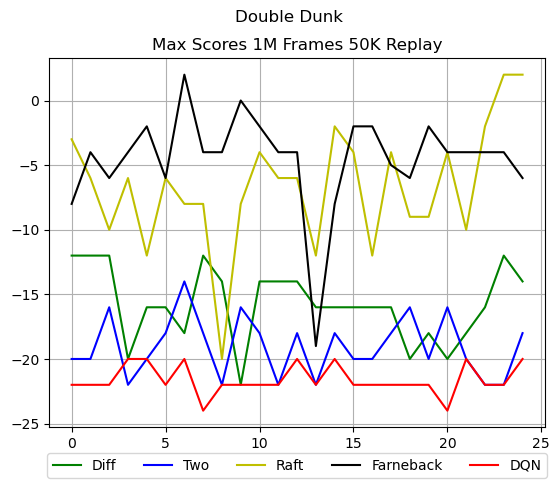

In [337]:
plt.plot(maxDifDunk, color='g', label='Diff')
plt.plot(maxTwoDunk, color='b', label='Two')
plt.plot(maxRaftDunk, color='y', label='Raft')
plt.plot(maxOptDunk, color='k', label='Farneback')
plt.plot(maxDDunk, color='r', label='DQN')
plt.title('Max Scores 1M Frames 50K Replay')
plt.suptitle('Double Dunk')
plt.grid('True')
plt.legend(loc='upper center', ncol=5, fancybox=True, bbox_to_anchor=(0.5, -0.05))
plt.show()

In [374]:
max(meanDifDunk), max(meanTwoDunk), max(meanRaftDunk), max(meanOptDunk)

(-18.133333, -20.466667, -10.266666, -8.9)

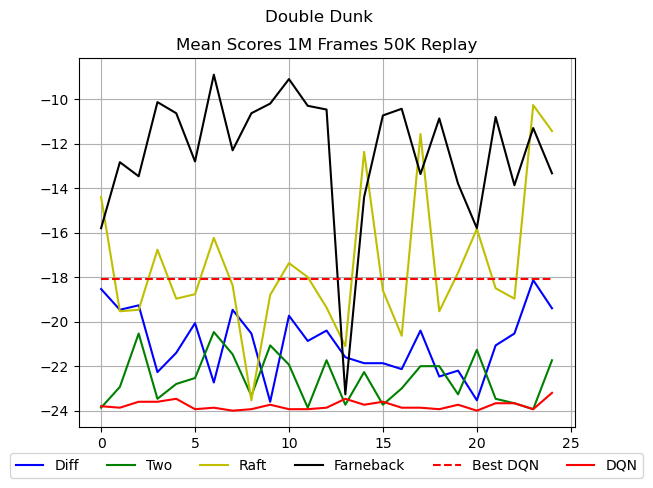

In [338]:
plt.plot(meanDifDunk, color='b', label='Diff')
plt.plot(meanTwoDunk, color='g', label='Two')
plt.plot(meanRaftDunk, color='y', label='Raft')
plt.plot(meanOptDunk, color='k', label='Farneback')
plt.plot([-18.1 for _ in range(25)], 'r--', label='Best DQN')
plt.plot(meanDDunk, color='r', label='DQN')
plt.title('Mean Scores 1M Frames 50K Replay')
plt.suptitle('Double Dunk')
plt.grid('True')
plt.legend(loc='upper center', ncol=6, fancybox=True, bbox_to_anchor=(0.5, -0.05))
plt.show()

In [339]:
maxOSpace, meanOSpace, minOSpace, argOSpace = find_stats('samples/SpaceInvaders_sample_rewards.pkl')

In [340]:
maxDSpace, meanDSpace, minDSpace, argDSpace = find_stats('samples/SpaceInvaders_DQNSample_rewards.pkl')

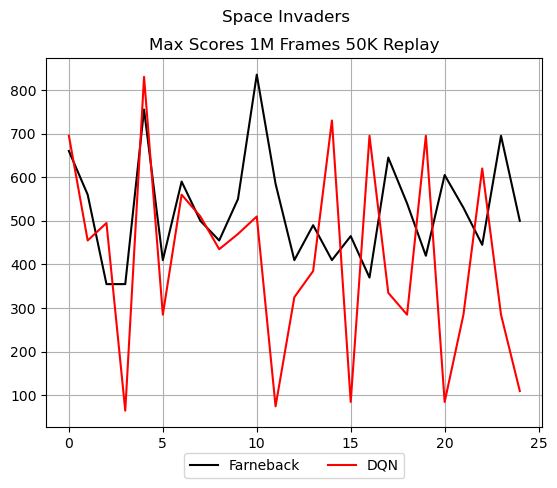

In [341]:
plt.plot(maxOSpace, color='k', label='Farneback')
plt.plot(maxDSpace, color='r', label='DQN')
plt.title('Max Scores 1M Frames 50K Replay')
plt.suptitle('Space Invaders')
plt.grid('True')
plt.legend(loc='upper center', ncol=2, fancybox=True, bbox_to_anchor=(0.5, -0.05))
plt.show()

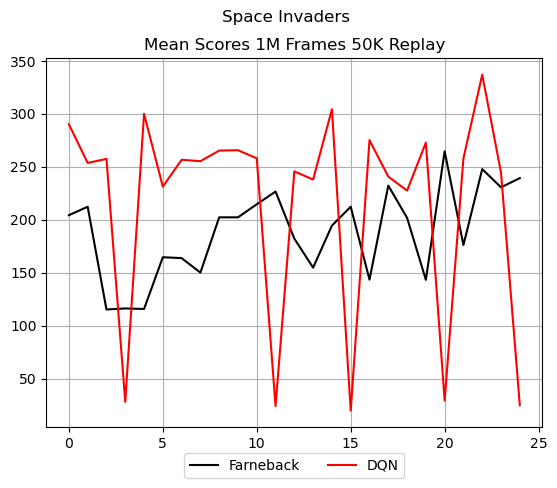

In [342]:
plt.plot(meanOSpace, color='k', label='Farneback')
plt.plot(meanDSpace, color='r', label='DQN')
plt.title('Mean Scores 1M Frames 50K Replay')
plt.suptitle('Space Invaders')
plt.grid('True')
plt.legend(loc='upper center', ncol=2, fancybox=True, bbox_to_anchor=(0.5, -0.05))
plt.show()

In [343]:
Pong50, Pong75, Pong100, Pong150 = open_pkl_file('samples/Pong_sample_rewards30.pkl')

In [344]:
maxOPong50, meanOPong50, minOPong50, argOPong50 = find_stats(rws=Pong50)

In [345]:
maxOPong75, meanOPong75, minOPong75, argOPong75 = find_stats(rws=Pong75)

In [346]:
maxOPong100, meanOPong100, minOPong100, argOPong100 = find_stats(rws=Pong100)

In [347]:
maxOPong150, meanOPong150, minOPong150, argOPong150 = find_stats(rws=Pong150)

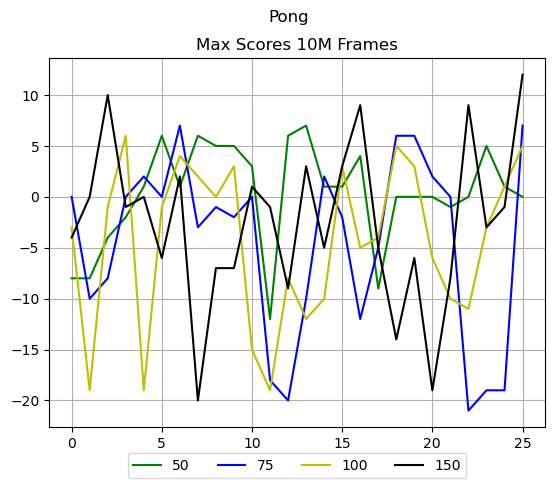

In [348]:
plt.plot(maxOPong50, color='g', label='50')
plt.plot(maxOPong75, color='b', label='75')
plt.plot(maxOPong100, color='y', label='100')
plt.plot(maxOPong150, color='k', label='150')
#plt.plot(maxDDunk, color='r', label='DQN')
plt.title('Max Scores 10M Frames')
plt.suptitle('Pong')
plt.grid('True')
plt.legend(loc='upper center', ncol=5, fancybox=True, bbox_to_anchor=(0.5, -0.05))
plt.show()

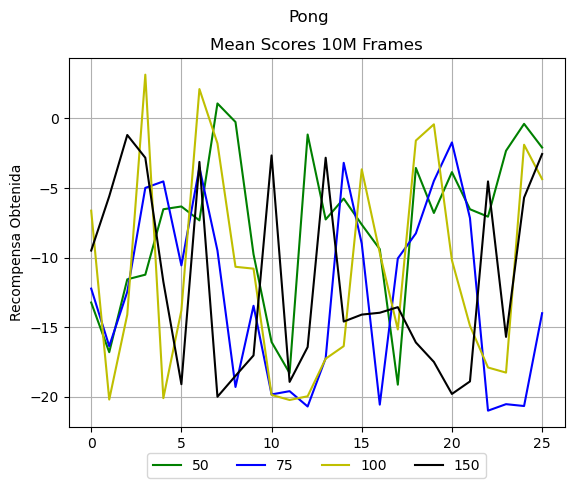

In [362]:
plt.plot(meanOPong50, color='g', label='50')
plt.plot(meanOPong75, color='b', label='75')
plt.plot(meanOPong100, color='y', label='100')
plt.plot(meanOPong150, color='k', label='150')
#plt.plot(maxDDunk, color='r', label='DQN')
plt.title('Mean Scores 10M Frames')
plt.suptitle('Pong')
plt.ylabel('Recompensa Obtenida')
plt.grid('True')
plt.legend(loc='upper center', ncol=5, fancybox=True, bbox_to_anchor=(0.5, -0.05))
plt.show()

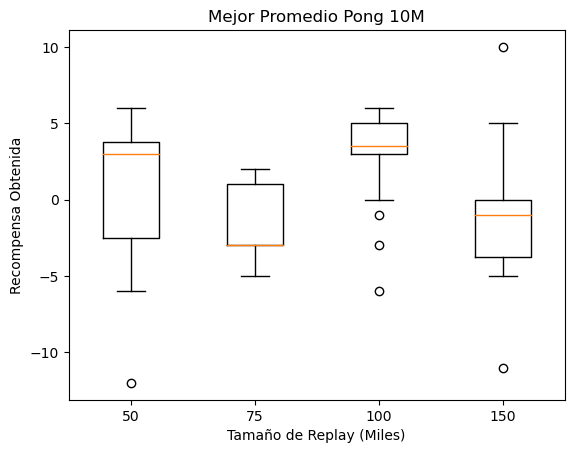

In [361]:
data = [argOPong50, argOPong75, argOPong100, argOPong150]
fig7, ax7 = plt.subplots()
ax7.set_title('Mejor Promedio Pong 10M')
ax7.boxplot(data, labels=[50,75,100,150])
ax7.set_xlabel('Tamaño de Replay (Miles)')
ax7.set_ylabel('Recompensa Obtenida')

plt.show()

### Previous Work

In [ ]:
rewards = []
for i in range(10):
    _, rw = sample('PongNoFrameskip-v4', model='dictsOpt\PongNoFrameskip-v4_opt/PongNoFrameskip-v4_opt_'+ str(i+1) +'.dat', n_samples=100, verbose=False)
    rewards.append(rw)

dictsOpt\PongNoFrameskip-v4_opt/PongNoFrameskip-v4_opt_1.dat: 100%|██████████| 100/100 [07:20<00:00,  4.40s/it]


-10.44


dictsOpt\PongNoFrameskip-v4_opt/PongNoFrameskip-v4_opt_2.dat: 100%|██████████| 100/100 [05:54<00:00,  3.54s/it]


-11.47


dictsOpt\PongNoFrameskip-v4_opt/PongNoFrameskip-v4_opt_3.dat: 100%|██████████| 100/100 [06:34<00:00,  3.94s/it]


-4.78


dictsOpt\PongNoFrameskip-v4_opt/PongNoFrameskip-v4_opt_4.dat: 100%|██████████| 100/100 [06:32<00:00,  3.92s/it]


-4.99


dictsOpt\PongNoFrameskip-v4_opt/PongNoFrameskip-v4_opt_5.dat: 100%|██████████| 100/100 [05:59<00:00,  3.60s/it]


0.26


dictsOpt\PongNoFrameskip-v4_opt/PongNoFrameskip-v4_opt_6.dat: 100%|██████████| 100/100 [06:01<00:00,  3.61s/it]


-12.86


dictsOpt\PongNoFrameskip-v4_opt/PongNoFrameskip-v4_opt_7.dat: 100%|██████████| 100/100 [06:02<00:00,  3.62s/it]


-0.82


dictsOpt\PongNoFrameskip-v4_opt/PongNoFrameskip-v4_opt_8.dat: 100%|██████████| 100/100 [05:49<00:00,  3.49s/it]


-10.53


dictsOpt\PongNoFrameskip-v4_opt/PongNoFrameskip-v4_opt_9.dat: 100%|██████████| 100/100 [05:56<00:00,  3.57s/it]


-14.43


dictsOpt\PongNoFrameskip-v4_opt/PongNoFrameskip-v4_opt_10.dat: 100%|██████████| 100/100 [05:35<00:00,  3.35s/it]

-14.81


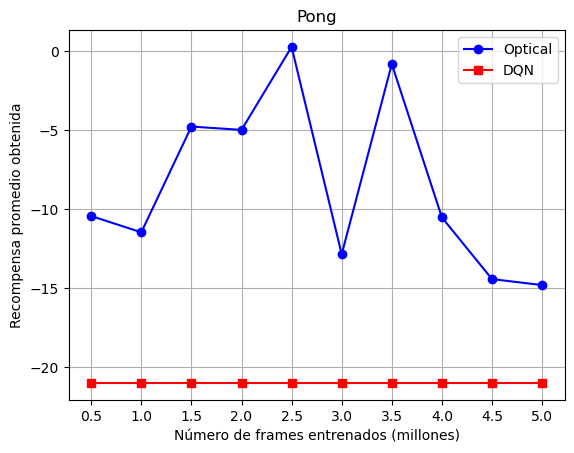

In [ ]:
plt.plot([.5,1,1.5,2,2.5,3,3.5,4,4.5,5], rewards, marker='o', linestyle='-', color='b', label='Optical')
plt.plot([.5,1,1.5,2,2.5,3,3.5,4,4.5,5], [-21 for _ in range(10)], marker='s', linestyle='-', color='r', label='DQN')
plt.xlabel('Número de frames entrenados (millones)')
plt.xticks([.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.ylabel('Recompensa promedio obtenida')
plt.title('Pong')
plt.legend()
plt.grid()
plt.show()

In [ ]:
rewardsBr = []
GAME_NAME = 'Breakout'
for i in range(10):
    _, rw = sample(GAME_NAME, i+1, n_samples=100, verbose=False)
    rewardsBr.append(rw)

dictsOpt/BreakoutNoFrameskip-v4_opt/BreakoutNoFrameskip-v4_opt_1.dat: 100%|██████████| 100/100 [08:08<00:00,  4.88s/it]


6.58


dictsOpt/BreakoutNoFrameskip-v4_opt/BreakoutNoFrameskip-v4_opt_2.dat: 100%|██████████| 100/100 [11:41<00:00,  7.01s/it]


8.32


dictsOpt/BreakoutNoFrameskip-v4_opt/BreakoutNoFrameskip-v4_opt_3.dat: 100%|██████████| 100/100 [10:51<00:00,  6.52s/it]


8.56


dictsOpt/BreakoutNoFrameskip-v4_opt/BreakoutNoFrameskip-v4_opt_4.dat: 100%|██████████| 100/100 [08:34<00:00,  5.15s/it]


8.06


dictsOpt/BreakoutNoFrameskip-v4_opt/BreakoutNoFrameskip-v4_opt_5.dat: 100%|██████████| 100/100 [05:28<00:00,  3.28s/it]


4.05


dictsOpt/BreakoutNoFrameskip-v4_opt/BreakoutNoFrameskip-v4_opt_6.dat: 100%|██████████| 100/100 [07:34<00:00,  4.54s/it]


7.53


dictsOpt/BreakoutNoFrameskip-v4_opt/BreakoutNoFrameskip-v4_opt_7.dat: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


6.37


dictsOpt/BreakoutNoFrameskip-v4_opt/BreakoutNoFrameskip-v4_opt_8.dat: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


6.0


dictsOpt/BreakoutNoFrameskip-v4_opt/BreakoutNoFrameskip-v4_opt_9.dat: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


6.86


dictsOpt/BreakoutNoFrameskip-v4_opt/BreakoutNoFrameskip-v4_opt_10.dat: 100%|██████████| 100/100 [03:14<00:00,  1.94s/it]

11.82


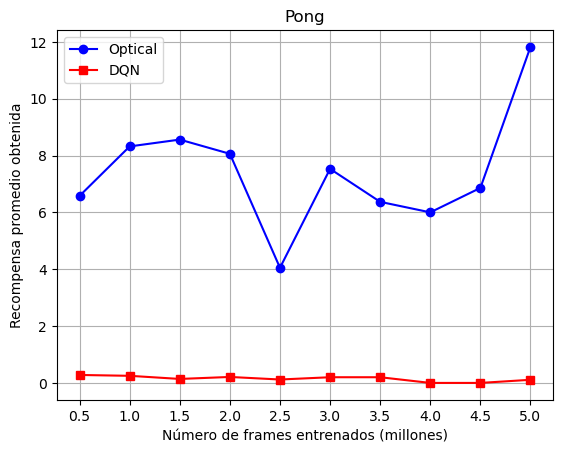

In [ ]:
plt.plot([.5,1,1.5,2,2.5,3,3.5,4,4.5,5], rewardsBr, marker='o', linestyle='-', color='b', label='Optical')
plt.plot([.5,1,1.5,2,2.5,3,3.5,4,4.5,5], [0.28, 0.25, 0.14, 0.21, 0.12, 0.2, 0.2, 0.0, 0.0, 0.11], marker='s', linestyle='-', color='r', label='DQN')
plt.xlabel('Número de frames entrenados (millones)')
plt.xticks([.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.ylabel('Recompensa promedio obtenida')
plt.title('Breakout')
plt.legend()
plt.grid()
plt.show()